In [99]:
from numpy import *
import numpy as np
import math
from matplotlib import pyplot as plt
from math import sqrt
import matplotlib
import time

%matplotlib inline


def drawDat(Dat):
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    ax.scatter(Dat[:,0].flatten().A[0],Dat[:,1].flatten().A[0],s=20,c='red')
    plt.xlim(0,len(Dat))
    plt.ylim(0,35)
    plt.show()

def Score(rV,Rh,predic,result):
    N=len(predic)
    sq1=sqrt(sum([(result[i]-predic[i])**2 for i in predic.iterkeys()])/N)
    sq2=sqrt(sum((predic[i])**2 for i in predic.iterkeys())/N)
    sq3=sqrt(sum((result[i])**2 for i in result.iterkeys())/N)
    return (1-sq1/(sq2+sq3))*(float(sum(rV))/float(sum(Rh)))*100

class f2d():
    def __init__(self,filepath):

        self.pool=[] # sampleI shape like datas
        self.sampleI=[0, #timeStamp
                      0,0,0,0,0, # Counts of flavor0 ~ flavor15
                      0,0,0,0,0,
                      0,0,0,0,0]
        self.legi={"flavor1":1,"flavor2":2,"flavor3":3,"flavor4":4,"flavor5":5,"flavor6":6,"flavor7":7,
                   "flavor8":8,"flavor9":9,"flavor10":10,"flavor11":11,"flavor12":12,"flavor13":13,
                   "flavor14":14,"flavor15":15}
        with open(filepath, 'r') as f:
            lines = f.readlines()

        self.stime=self.date2read(lines[0].strip().split('\t')[2])

        for line in lines:
            self.mkpool(line)
        for i in range(len(self.pool)):
            self.pool[i][0]=i+1

    def time2read(self,dt):
        dt = dt.split('\t')[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d %H:%M:%S'))

    def date2read(self,dt):
        dt = dt.split()[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d')) # %H:%M:%S'))

    def hour2read(self,dt):
        dt = dt.split(":")[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d %H')) #:%M:%S'))

    def timeMh(self,d1,d2):
        #return int((d1-d2)/604800) #a week
        #return int((d1-d2)/7200) #a hour
        return int((d1-d2)/86400) #a day

    def mkpool(self,raw):
        flavor,tm=raw.strip().split("\t")[1:]
        TM=self.time2read(tm)
        if flavor in self.legi:
            hourTM=self.timeMh(TM,self.stime)
            #pint hourTM
            while hourTM - len(self.pool) >= 0:
                sample = self.sampleI[:]
                self.pool.append(sample)  
                
            if self.pool[hourTM][self.legi[flavor]] < 15:
                self.pool[hourTM][self.legi[flavor]]+=1

    def appendDat(self,filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            self.mkpool(line)

        for i in range(len(self.pool)):
            self.pool[i][0]=i+1

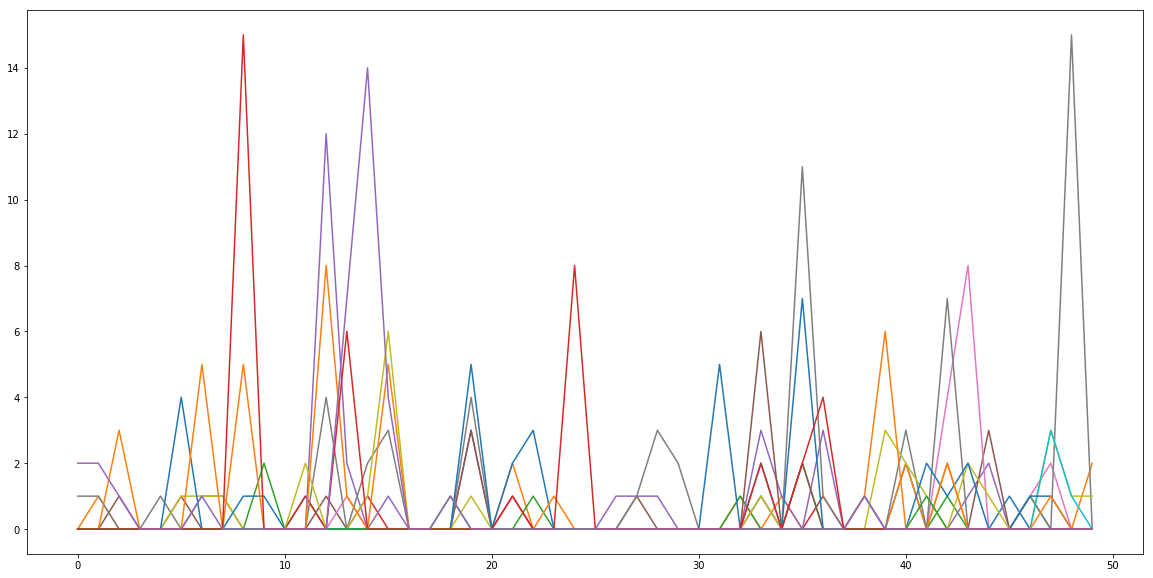

In [100]:
trainSet=f2d("example/TrainData_2015.1.1_2015.2.19.txt")
trainMat=mat(trainSet.pool)
fig=plt.figure(figsize=(20,10))
plt.plot(trainMat[:,1:])
plt.show()


(750,)


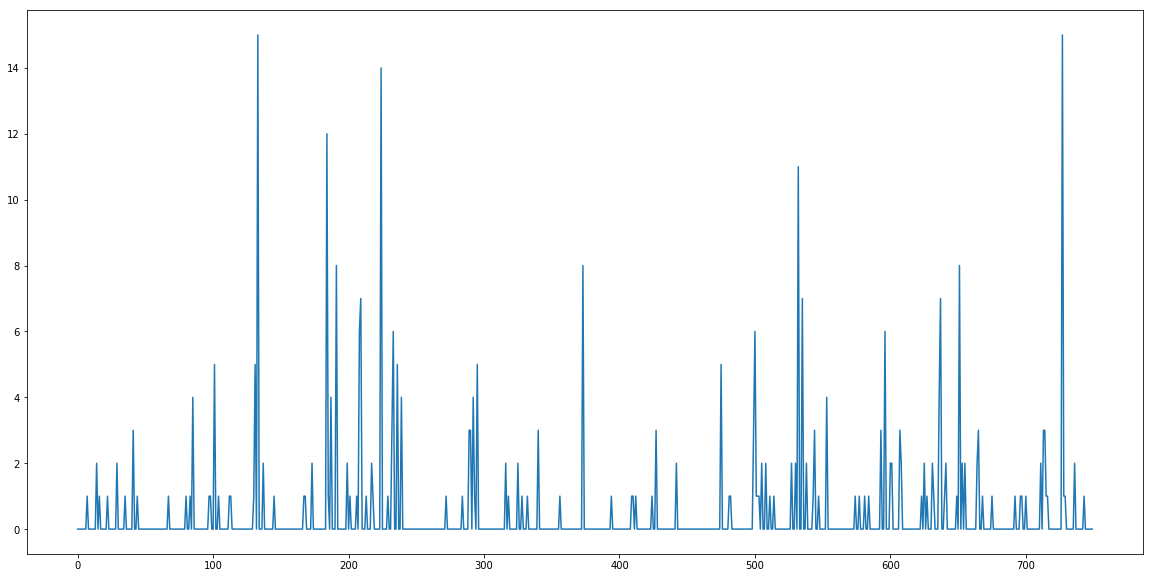

In [101]:
rMat=trainMat[:,1:].flatten().A[0]
print rMat.shape
fig=plt.figure(figsize=(20,10))
plt.plot(rMat)


(855,)


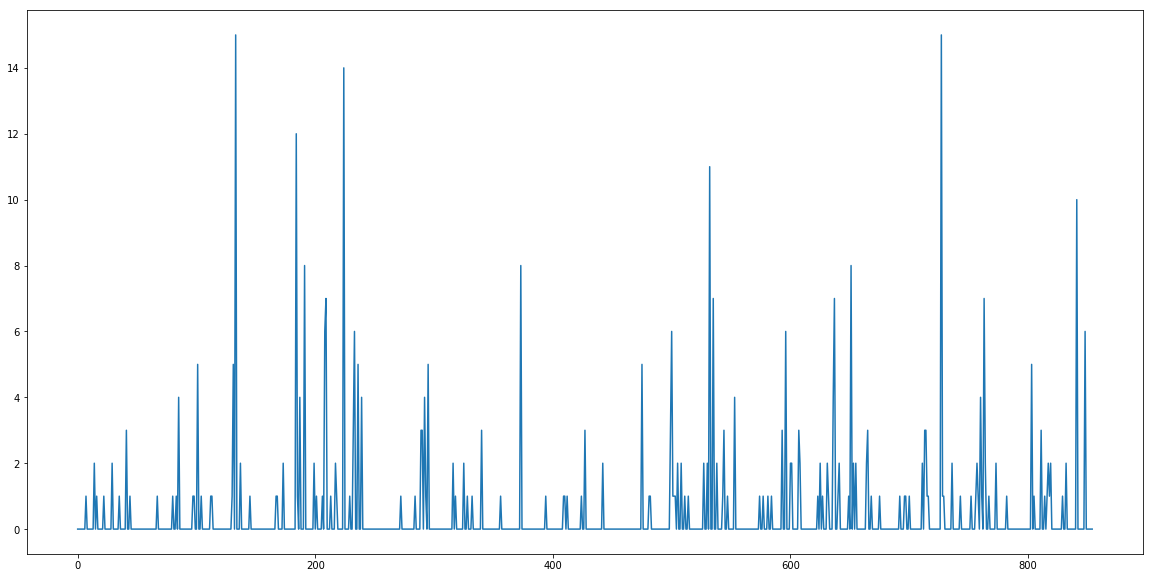

In [102]:
trainSet.appendDat("example/TestData_2015.2.20_2015.2.27.txt")
trainMat=mat(trainSet.pool)
rMat2=trainMat[:,1:].flatten().A[0]

print rMat2.shape

fig=plt.figure(figsize=(20,10))
plt.plot(rMat2)

In [90]:
history_data=rMat.tolist()
#print history_data
n = rMat.shape[0]

#print n
X0 = rMat
#print X0

#累加生成
history_data_agg = [sum(history_data[0:i+1]) for i in range(n)]
X1 = np.array(history_data_agg)

#计算数据矩阵B和数据向量Y
B = np.zeros([n-1,2])
Y = np.zeros([n-1,1])
for i in range(0,n-1):
    B[i][0] = -0.5*(X1[i] + X1[i+1])
    B[i][1] = 1
    Y[i][0] = X0[i+1]

#计算GM(1,1)微分方程的参数a和u
#A = np.zeros([2,1])
A = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)
a = A[0][0]
u = A[1][0]

#建立灰色预测模型
XX0 = np.zeros(n)
XX0[0] = X0[0]
for i in range(1,n):
    XX0[i] = (X0[0] - u/a)*(1-math.exp(a))*math.exp(-a*(i));


#模型精度的后验差检验
e = 0      #求残差平均值
for i in range(0,n):
    e += (X0[i] - XX0[i])
e /= n

#求历史数据平均值
aver = 0;     
for i in range(0,n):
    aver += X0[i]
aver /= n

#求历史数据方差
s12 = 0;     
for i in range(0,n):
    s12 += (X0[i]-aver)**2;
s12 /= n

#求残差方差
s22 = 0;       
for i in range(0,n):
    s22 += ((X0[i] - XX0[i]) - e)**2;
s22 /= n

#求后验差比值
C = s22 / s12   

#求小误差概率
cout = 0
for i in range(0,n):
    if abs((X0[i] - XX0[i]) - e) < 0.6754*math.sqrt(s12):
        cout = cout+1
    else:
        cout = cout
P = cout / n
"""
m = 30   #请输入需要预测的年数
#print('往后m各年负荷为：')
f = np.zeros(m)
for i in range(0,m):
        f[i] = (X0[0] - u/a)*(1-math.exp(a))*math.exp(-a*(i+n))
"""      
if (C < 0.35 and P > 0.95):
    #预测精度为一级
    m = 15   #请输入需要预测的年数
    #print('往后m各年负荷为：')
    f = np.zeros(m)
    for i in range(0,m):
        f[i] = (X0[0] - u/a)*(1-math.exp(a))*math.exp(-a*(i+n))    
else:
    print('灰色预测法不适用')
    
#print f

灰色预测法不适用
